CartPole을 연속 행동으로 감싸서 SAC 학습

같은 CartPole에 대해 PPO, DQN도 학습

EvalCallback으로 평가 곡선 로그 남기고, 마지막에 비교 플롯

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



==== 학습 시작: SAC ====
Using cuda device


c:\Users\user\anaconda3\envs\vissim_rl\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 25.8      |
|    ep_rew_mean     | 25.8      |
| time/              |           |
|    episodes        | 4         |
|    fps             | 11        |
|    time_elapsed    | 9         |
|    total_timesteps | 103       |
| train/             |           |
|    actor_loss      | -0.755    |
|    critic_loss     | 2.31      |
|    ent_coef        | 1         |
|    ent_coef_loss   | -0.000492 |
|    learning_rate   | 0.0003    |
|    n_updates       | 2         |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | 26.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 19       |
|    time_elapsed    | 10       |
|    total_timesteps | 209      |
| train/             |          |
|    actor_loss      | -2.86    |
|    critic_loss     | 0.131   

c:\Users\user\anaconda3\envs\vissim_rl\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.1     |
|    ep_rew_mean     | 22.1     |
| time/              |          |
|    fps             | 63       |
|    iterations      | 1        |
|    time_elapsed    | 32       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 29         |
|    ep_rew_mean          | 29         |
| time/                   |            |
|    fps                  | 81         |
|    iterations           | 2          |
|    time_elapsed         | 50         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00899988 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.686     |
|    explained_variance   | 0.00607    |
|    learning_rate        | 0.0003     |
|   

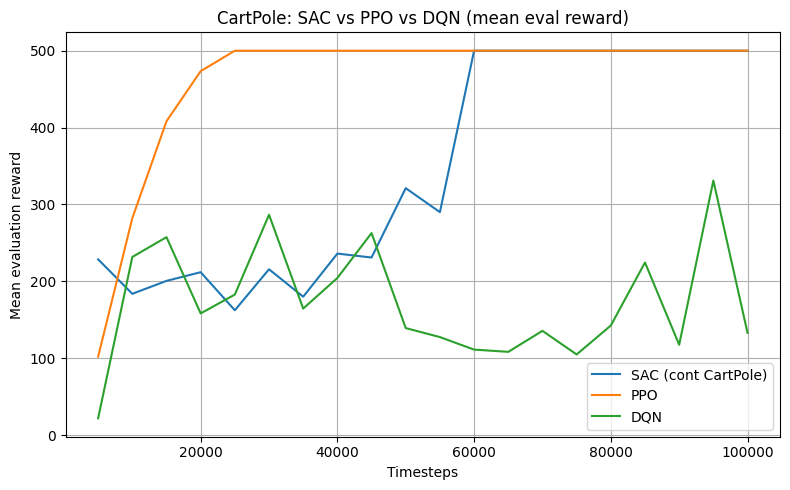

In [1]:
import os
from typing import Callable, Tuple

import gymnasium as gym
import numpy as np
from gymnasium import spaces

from stable_baselines3 import SAC, PPO, DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt


# -------------------------------
# 1) 연속 행동 CartPole 래퍼
# -------------------------------
class ContinuousCartPoleEnv(gym.Env):
    """
    CartPole-v1 위에 얹는 연속 행동 래퍼.
    - 원래 CartPole은 Discrete(2) 행동 공간 (왼/오른쪽)
    - 여기서는 Box(-1, 1) 연속 행동을 받아 0/1 로 threshold 하여 전달
    """
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 50}

    def __init__(self, render_mode=None):
        super().__init__()
        self.render_mode = render_mode
        self._env = gym.make("CartPole-v1", render_mode=render_mode)

        # 관측 공간은 그대로
        self.observation_space = self._env.observation_space
        # 행동 공간을 연속 [-1, 1] 로 정의
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )

    def reset(self, seed: int | None = None, options: dict | None = None):
        obs, info = self._env.reset(seed=seed, options=options)
        return obs, info

    def step(self, action: np.ndarray):
        # 연속 action[0] 을 0/1 로 매핑
        discrete_action = 1 if action[0] > 0.0 else 0
        obs, reward, terminated, truncated, info = self._env.step(discrete_action)
        return obs, reward, terminated, truncated, info

    def render(self):
        return self._env.render()

    def close(self):
        self._env.close()


# -------------------------------
# 2) 공통 학습 + 평가 유틸
# -------------------------------
def train_with_eval(
    algo_name: str,
    model_cls,
    make_env_fn: Callable[[], gym.Env],
    total_timesteps: int,
    log_dir: str,
    **model_kwargs,
) -> Tuple[object, Tuple[float, float]]:
    """
    공통 학습 함수
    - algo_name: "sac"/"ppo"/"dqn" 등
    - model_cls: SAC / PPO / DQN 클래스
    - make_env_fn: gym.Env 를 하나 생성하는 함수
    - total_timesteps: 학습 스텝 수
    - log_dir: 로그/모델 저장 디렉토리
    """
    os.makedirs(log_dir, exist_ok=True)

    # 벡터화된 학습 환경 (1개 env)
    train_env = make_vec_env(
        make_env_fn,
        n_envs=1,
        monitor_dir=log_dir,  # Monitor로 episode reward/length 기록
    )

    # 평가용 환경 (VecEnv 아님, 단일 env)
    eval_env = Monitor(make_env_fn(), log_dir)

    # 주기적으로 평가, 결과는 evaluations.npz로 저장
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=log_dir,
        log_path=log_dir,
        eval_freq=5_000,
        n_eval_episodes=10,
        deterministic=True,
        render=False,
    )

    print(f"\n==== 학습 시작: {algo_name.upper()} ====")
    model = model_cls(
        "MlpPolicy",
        train_env,
        verbose=1,
        **model_kwargs,
    )
    model.learn(total_timesteps=total_timesteps, callback=eval_callback)

    # 최종 정책 평가
    mean_reward, std_reward = evaluate_policy(
        model, eval_env, n_eval_episodes=20, deterministic=True
    )
    print(
        f"[{algo_name.upper()}] 최종 평가: "
        f"mean_reward={mean_reward:.2f}, std={std_reward:.2f}"
    )

    eval_env.close()
    train_env.close()

    return model, (mean_reward, std_reward)


def plot_learning_curves(experiments: list[tuple[str, str]]):
    """
    EvalCallback이 저장한 evaluations.npz 로부터
    timestep-mean_reward 곡선 플롯
    experiments: [(label, log_dir), ...]
    """
    plt.figure(figsize=(8, 5))

    for label, log_dir in experiments:
        eval_path = os.path.join(log_dir, "evaluations.npz")
        if not os.path.exists(eval_path):
            print(f"[경고] {label} 에 대한 {eval_path} 파일이 없습니다. 건너뜀.")
            continue

        data = np.load(eval_path)
        timesteps = data["timesteps"]  # shape: (n_eval,)
        results = data["results"]      # shape: (n_eval, n_eval_episodes)
        mean_rewards = results.mean(axis=1)

        plt.plot(timesteps, mean_rewards, label=label)

    plt.xlabel("Timesteps")
    plt.ylabel("Mean evaluation reward")
    plt.title("CartPole: SAC vs PPO vs DQN (mean eval reward)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -------------------------------
# 3) main: SAC vs PPO vs DQN
# -------------------------------
def main():
    TOTAL_TIMESTEPS = 100_000  # 과제 규모에 맞게 조정 가능

    # 1) SAC: 연속 행동 CartPole 래퍼 사용
    sac_log_dir = "./logs/sac_cartpole"
    sac_model, sac_eval = train_with_eval(
        algo_name="sac",
        model_cls=SAC,
        make_env_fn=lambda: ContinuousCartPoleEnv(),
        total_timesteps=TOTAL_TIMESTEPS,
        log_dir=sac_log_dir,
        # 필요시 하이퍼파라미터 조정
        learning_rate=3e-4,
        gamma=0.99,
        buffer_size=100_000,
        batch_size=64,
        tau=0.005,
        train_freq=1,
        gradient_steps=1,
    )

    # 2) PPO: 기본 CartPole (이산 행동)
    ppo_log_dir = "./logs/ppo_cartpole"
    ppo_model, ppo_eval = train_with_eval(
        algo_name="ppo",
        model_cls=PPO,
        make_env_fn=lambda: gym.make("CartPole-v1"),
        total_timesteps=TOTAL_TIMESTEPS,
        log_dir=ppo_log_dir,
        gamma=0.99,
        n_steps=2048,
        learning_rate=3e-4,
        batch_size=64,
        ent_coef=0.0,
    )

    # 3) DQN: 기본 CartPole (이산 행동)
    dqn_log_dir = "./logs/dqn_cartpole"
    dqn_model, dqn_eval = train_with_eval(
        algo_name="dqn",
        model_cls=DQN,
        make_env_fn=lambda: gym.make("CartPole-v1"),
        total_timesteps=TOTAL_TIMESTEPS,
        log_dir=dqn_log_dir,
        learning_rate=1e-3,
        buffer_size=50_000,
        learning_starts=1_000,
        batch_size=64,
        tau=1.0,
        gamma=0.99,
        train_freq=4,
        target_update_interval=1_000,
    )

    print("\n==== 최종 요약 (20-episode 평균 리워드 기준) ====")
    print(f"SAC : mean={sac_eval[0]:.2f}, std={sac_eval[1]:.2f}")
    print(f"PPO : mean={ppo_eval[0]:.2f}, std={ppo_eval[1]:.2f}")
    print(f"DQN : mean={dqn_eval[0]:.2f}, std={dqn_eval[1]:.2f}")

    # 학습 과정 비교 플롯
    experiments = [
        ("SAC (cont CartPole)", sac_log_dir),
        ("PPO", ppo_log_dir),
        ("DQN", dqn_log_dir),
    ]
    plot_learning_curves(experiments)


if __name__ == "__main__":
    main()
